# Bird Classifier using Transfer Learning from MobileNetv2

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax

In [2]:
ROUND_1_TRAINABLE_LAYERS = 0 # layers at end of the mobile_net base model to have trainable parameters
ROUND_1_EPOCHS = 10

ROUND_2_TRAINABLE_LAYERS = 38
ROUND_2_LEARNING_SCALER = 0.2
ROUND_2_EPOCHS = 10

ROUND_3_TRAINABLE_LAYERS = 74
ROUND_3_LEARNING_SCALER = 0.2
ROUND_3_EPOCHS = 10

LEARNING_RATE = 0.001

In [3]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        if not os.path.isdir(foldpath):
            continue
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    # valid dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [4]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
#     test_batch_size = batch_size
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [7]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Model Structure

In [9]:
# Get Dataframes
train_dir = '../Kaggle500Dataset/train'
valid_dir = '../Kaggle500Dataset/valid'
test_dir = '../Kaggle500Dataset/test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

Found 81950 validated image filenames belonging to 510 classes.
Found 2550 validated image filenames belonging to 510 classes.
Found 2550 validated image filenames belonging to 510 classes.


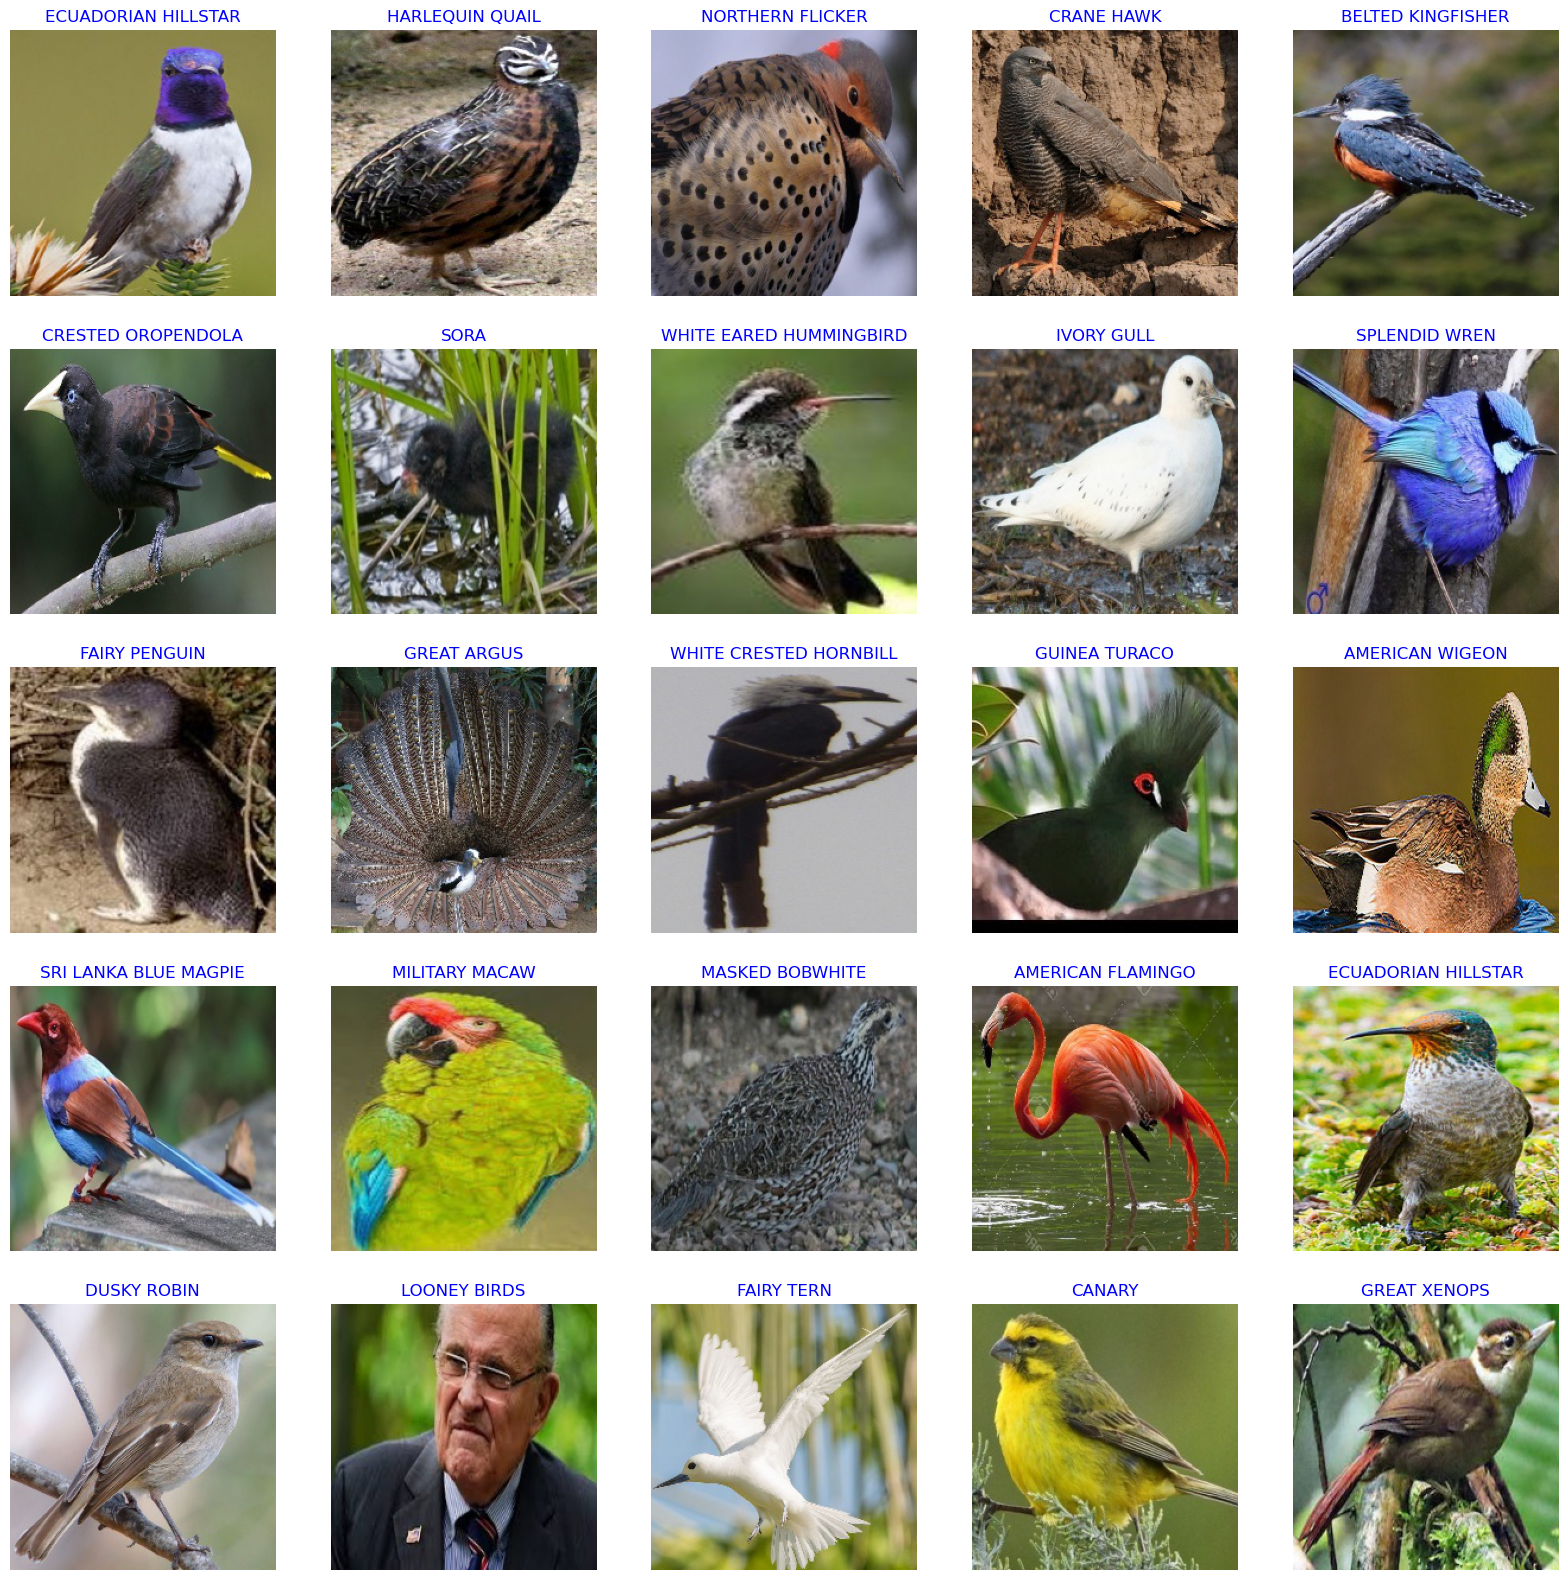

In [10]:
# Get Generators
batch_size = 128
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

# Data Augmentation

In [11]:
# Creating Data Augmentation Layer With horizontal and vertical flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255)
], name='DataAugmentationLayer')

# Create model

In [12]:
# Create Model Structure
img_size = (224, 224)
IMAGE_SHAPE = img_size + (3,)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
# 1. Creating A Base Model With tf.keras.applications
base_model = MobileNetV2(input_shape = IMAGE_SHAPE,
                          include_top = False,
                          weights = 'imagenet')

# 2. Freezing The Base Model
base_model.trainable = False

# 3. Creating Inputs Into Our Model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='InputLayer')

# 4. Adding Data Augmentation Sequential Model As A Layer
x = data_augmentation(inputs)

# 4. Passing The Inputs To The Base Model
x = base_model(x, training=False)

# global average pool to collapse to 1D
x = GlobalAveragePooling2D()(x) 
# normalize layer
x = BatchNormalization()(x)
# apply relu activation
x = ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = Dropout(0.25)(x)
# densely connected layer with 2000
x = Dense(1500)(x) 
# normalize layer
x = BatchNormalization()(x)
# apply relu activation
x = ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = Dense(1200)(x) 
# normalize layer
x = BatchNormalization()(x)
# apply relu activation
x = ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = Dense(900)(x) 
# normalize layer
x = BatchNormalization()(x)
# apply relu activation
x = ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = Dropout(0.25)(x)
# densely connected output layer with same number of output classes

outputs = Dense(class_count, activation= 'softmax')(x)

# 7. Combining The Inputs With The Outputs Into A Model
model = tf.keras.Model(inputs, outputs)

model.compile(Adamax(learning_rate= LEARNING_RATE), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentationLayer (Sequ  (None, 224, 224, 3)      0         
 ential)                                                         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                               

In [13]:
batch_size = 128
epochs = ROUND_1_EPOCHS
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
freeze = False
ask_epoch = 10
batches = int(np.ceil(len(train_gen.labels) / batch_size))

In [14]:
callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= None )]

In [15]:
history = model.fit(x= train_gen, 
                    epochs= epochs, 
                    verbose= 0,
                    callbacks= callbacks,
                    validation_data= valid_gen)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


2023-03-26 19:18:27.946662: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1 /10     5.987    1.631   5.80469   2.588   0.00100  0.00100  accuracy     0.00    424.36 
 2 /10     5.495    3.701   5.62950   3.647   0.00100  0.00100  accuracy    126.85   426.17 
 3 /10     5.292    5.047   5.57780   4.392   0.00100  0.00100  accuracy    36.37    424.23 
 4 /10     5.169    6.045   5.42305   5.529   0.00100  0.00100  accuracy    19.78    425.15 
 5 /10     5.095    6.597   5.50744   5.294   0.00100  0.00100  accuracy     9.12    422.89 
 6 /10     5.023    7.131   5.39443   5.804   0.00100  0.00100  accuracy     8.10    426.71 
 7 /10     4.975    7.699   5.39598   5.961   0.00100  0.00100  accuracy     7.96    423.62 
 8 /10     4.930    8.023   5.36207   6.078   0.00100  0.00100  accuracy     4.22    424.70 
 9 /10     4.897    8.334   5.38218   6.157   0.00100  0.00100  accuracy     3.88    424.31 
10 /10     4.861    8.561   5.29912   7.137   0.00100  0.00100  accuracy     2.72    426.35 
training elapsed time was 1.0 hours, 10.0 minutes, 48.66 seconds)


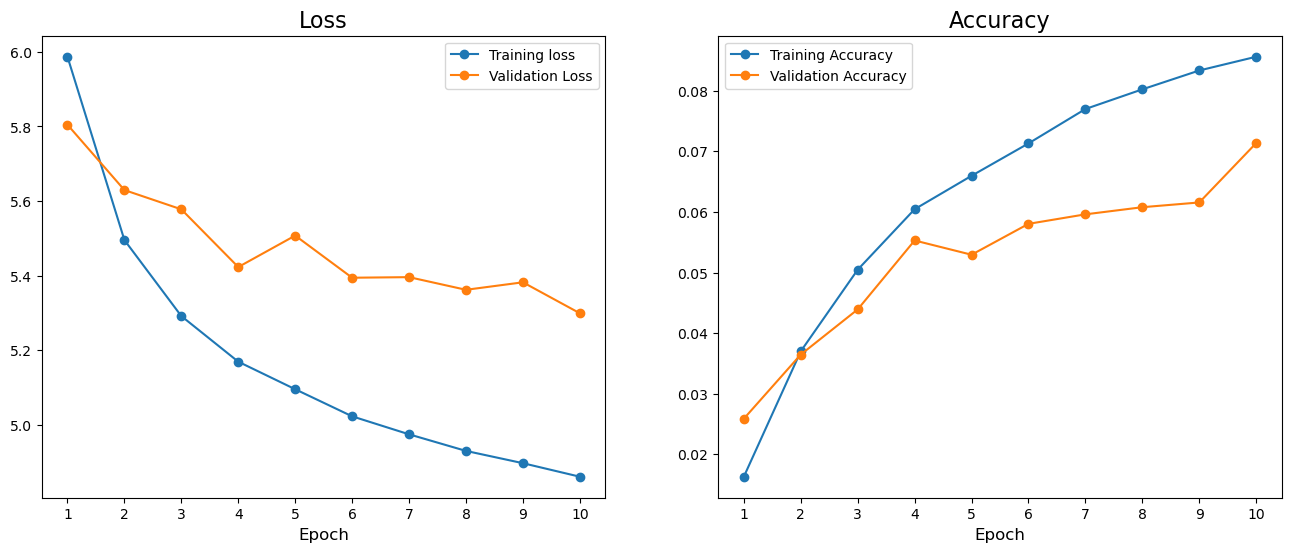

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = epochs

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [17]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

34/34 [==============================] - 11s 332ms/step - loss: 5.3842 - accuracy: 0.0584
Train Loss:  5.1396565437316895
Train Accuracy:  0.06916360557079315
--------------------
Validation Loss:  5.299117088317871
Validation Accuracy:  0.07137254625558853
--------------------
Test Loss:  5.384212493896484
Test Accuracy:  0.05843137204647064


In [18]:
model_name = 'MobileNetV2'
subject = 'Birds-Species'
acc = test_score[1] * 100
save_path = ''

save_id = str(f'./Models/MobileNetV2/{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as ./Models/MobileNetV2/MobileNetV2-Birds-Species-5.84.h5


# Fine tune

In [20]:
model.layers[2].trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_2_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_2_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 38 layers in the Mobile Net Base Model to trainable!


In [21]:
optimizer_2 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_2_LEARNING_SCALER)

model.compile(Adamax(learning_rate= LEARNING_RATE), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentationLayer (Sequ  (None, 224, 224, 3)      0         
 ential)                                                         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                               

In [22]:
callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 10, epochs= 20, ask_epoch= None ),
             model.history]

In [23]:
history = model.fit(x= train_gen, 
                    epochs= ROUND_2_EPOCHS, 
                    callbacks= callbacks,
                    verbose= 0,
                    validation_data= valid_gen)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /20     6.003    1.015  208.98027  0.196   0.00100  0.00100  accuracy     0.00    516.54 
 2 /20     5.634    1.556  135.15385  0.196   0.00100  0.00100  accuracy    53.25    519.43 
 3 /20     5.490    1.998  148.09853  0.314   0.00100  0.00100  accuracy    28.39    517.26 
 4 /20     5.433    2.129  452.91989  0.196   0.00100  0.00100  accuracy     6.60    525.03 
 5 /20     5.341    2.420  193.00821  0.196   0.00100  0.00100  accuracy    13.64    525.13 
 6 /20     5.316    2.550  183.19951  0.314   0.00100  0.00100  accuracy     5.40    523.10 
 7 /20     5.353    2.270  233.15779  0.196   0.00100  0.00050  accuracy    -11.00   520.66 
 8 /20     5.227    2.932  133.25967  0.196   0.00050  0.00050  accuracy    14.98    654.86 
 9 /20     5.187    3.042  45.54858   0.196   0.00050  0.00050  accuracy     3.75    530.34 
10 /20     5.115    3.390  55.55015   0.392   0.00050  0.00050  accurac

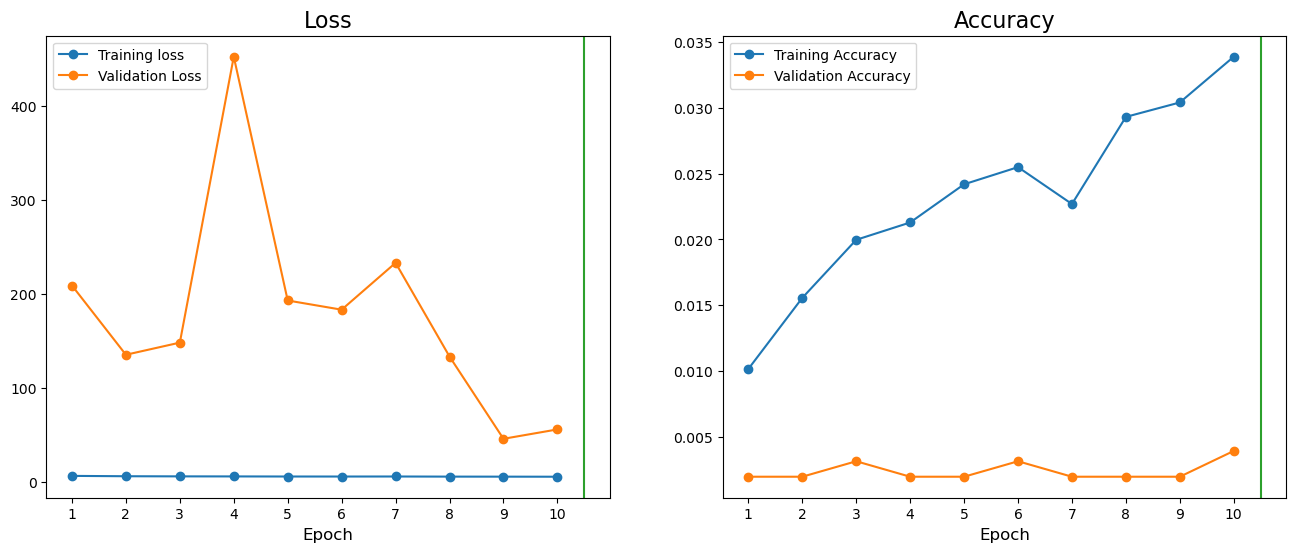

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

# total_epochs += ROUND_2_EPOCHS
total_epochs = 10
new_rounds = [ROUND_1_EPOCHS + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize)

for new_round in new_rounds:
    ax1.axvline(new_round, c='tab:green')
    ax2.axvline(new_round, c='tab:green');

In [28]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

34/34 [==============================] - 12s 341ms/step - loss: 55.5774 - accuracy: 0.0035
Train Loss:  55.30961990356445
Train Accuracy:  0.0034466912038624287
--------------------
Validation Loss:  55.550148010253906
Validation Accuracy:  0.003921568859368563
--------------------
Test Loss:  55.57740783691406
Test Accuracy:  0.0035294117406010628


In [29]:
model_name = 'MobileNetV2'
subject = 'Birds-Species'
acc = test_score[1] * 100
save_path = ''

save_id = str(f'./Models/MobileNetV2/{model_name}-{subject}-FineTune1-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as ./Models/MobileNetV2/MobileNetV2-Birds-Species-FineTune1-0.35.h5


# Fine Tune again

In [30]:
model.layers[2].trainable = True
print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_3_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_3_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 74 layers in the Mobile Net Base Model to trainable!


In [31]:
optimizer_3 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_3_LEARNING_SCALER)

model.compile(Adamax(learning_rate= LEARNING_RATE), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentationLayer (Sequ  (None, 224, 224, 3)      0         
 ential)                                                         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                               

In [32]:
callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 20, epochs= 30, ask_epoch= None ),
             model.history]

In [34]:
history = model.fit(x= train_gen, 
                    validation_data=valid_gen, 
                    verbose= 0,
                    epochs=ROUND_3_EPOCHS, 
                    callbacks = callbacks)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /30     6.075    0.617  120.53400  0.196   0.00100  0.00100  accuracy     0.00    648.01 
 2 /30     5.772    1.181  61.77050   0.314   0.00100  0.00100  accuracy    91.30    637.80 
 3 /30     5.588    1.574  141.19284  0.392   0.00100  0.00100  accuracy    33.26    625.52 
 4 /30     5.336    2.425  48.09954   0.275   0.00100  0.00100  accuracy    54.03    625.29 
 5 /30     5.091    3.573  69.29082   0.196   0.00100  0.00100  accuracy    47.36    628.65 
 6 /30     4.970    4.156  28.10624   0.431   0.00100  0.00100  accuracy    16.33    627.22 
 7 /30     4.827    5.041  24.15134   0.275   0.00100  0.00100  accuracy    21.29    627.86 
 8 /30     4.777    5.306  11.56610   0.706   0.00100  0.00100  accuracy     5.25    626.16 
 9 /30     4.702    5.744  11.98158   0.588   0.00100  0.00100  accuracy     8.26    625.45 
10 /30     4.637    6.299  15.65394   0.706   0.00100  0.00100  accurac

ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

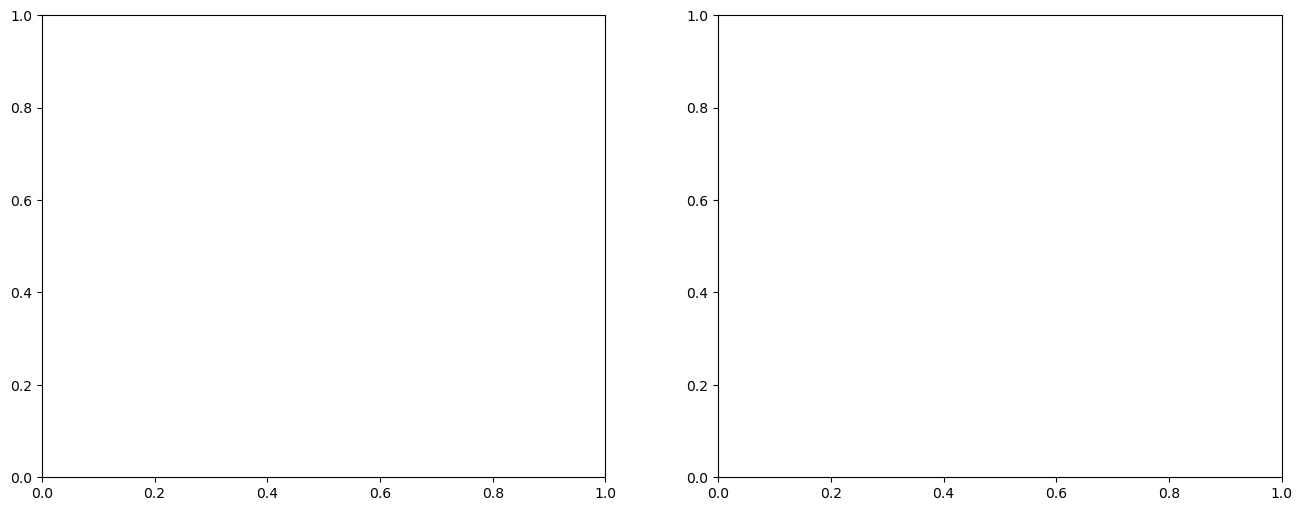

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs += ROUND_3_EPOCHS
new_rounds += [ROUND_1_EPOCHS + ROUND_2_EPOCHS + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

for new_round in new_rounds:
    ax1.axvline(new_round, c='tab:green')
    ax2.axvline(new_round, c='tab:green');

In [36]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

34/34 [==============================] - 11s 316ms/step - loss: 15.6997 - accuracy: 0.0051
Train Loss:  15.660957336425781
Train Accuracy:  0.005514706019312143
--------------------
Validation Loss:  15.653938293457031
Validation Accuracy:  0.0070588234812021255
--------------------
Test Loss:  15.699710845947266
Test Accuracy:  0.005098039284348488


In [37]:
model_name = 'MobileNetV2'
subject = 'Birds-Species'
acc = test_score[1] * 100
save_path = ''

save_id = str(f'./Models/MobileNetV2/{model_name}-{subject}-FineTune2-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as ./Models/MobileNetV2/MobileNetV2-Birds-Species-FineTune2-0.51.h5
